In [ ]:
!pip install threadpoolctl -U
!pip install PyNomaly
!pip install ipynb

In [1]:
from ipynb.fs.full.LocalOutlierProbabilities import *
from ipynb.fs.full.utils import *
from ipynb.fs.full.KNearestNeighbours import *
from ipynb.fs.full.RadiusNeighbours import *

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.spatial import distance


## Compare epsilon performance

In [3]:
def run_IOU_point(X, y, params, dist_type, break_early=False):
    epsilon = 0

    values_epsilon = []
    value_IOU_nn = []
    value_IOU_loop = []
    value_IOU_lrd = []
    value_IOU_lof = []

    for i in range (0, 100):
        epsilon += 0.01
        #Get true overlap
        if dist_type == "norm":
            f1_distribution = stats.norm.pdf(x=X, loc=params[0], scale=params[1])
            f2_distribution = stats.norm.pdf(x=X, loc=params[2], scale=params[3])
        
        if dist_type == "uni":
            f1_distribution = stats.norm.pdf(x=X, loc=params[0], scale=params[1]-params[0])
            f2_distribution = stats.norm.pdf(x=X, loc=params[2], scale=params[3]-params[2])

        class_ov = (f1_distribution > epsilon) & (f2_distribution > epsilon)
        overlap = X[class_ov]
        
        y_true = []
        for data in X:
            if len(overlap) == 0:
                y_true.append(0)
                if break_early:
                    return  values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd
            elif data > overlap.min() and data < overlap.max():
                y_true.append(1)
            else:
                y_true.append(0)

        #Estimated Overlap by the Nearest Neighbour
        overlap_nn = Radius_Neighbours.fit_predict(X, y, epsilon)
        overlap_lof, overlap_lrd = K_Nearest_Neighbours.fit_predict(X, y, epsilon)
        overlap_loop = LoOP.fit_predict(X, y, epsilon, k=None, Plotting=False)
    
        if len(overlap_nn) == 0:
            overlap_nn = [0 for i in range(len(y_true))]
        
        if overlap_lof is None:
            overlap_lof = [0 for i in range(len(y_true))]
            
        if overlap_lrd is None:
            overlap_lrd = [0 for i in range(len(y_true))]
        
        if len(overlap_loop) == 0:
            overlap_loop = [0 for i in range(len(y_true))]
        
        iou_nn, _, _ = iou_acc_multiple_dim(X, overlap_nn, y_true)
        iou_loop, _, _ = iou_acc_multiple_dim(X, overlap_loop, y_true)
        iou_lof, _, _ = iou_acc_multiple_dim(X, overlap_lof, y_true)
        iou_lrd, _, _ = iou_acc_multiple_dim(X, overlap_lrd, y_true)

        values_epsilon.append(epsilon)
        value_IOU_nn.append(iou_nn)
        value_IOU_loop.append(iou_loop)
        value_IOU_lof.append(iou_lof)
        value_IOU_lrd.append(iou_lrd)
        
    return values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd


def run_IOU_Area(X, y, params, dist_type, break_early=False):
    epsilon = 0

    values_epsilon = []
    value_IOU_nn = []
    value_IOU_loop = []
    value_IOU_lof = []
    value_IOU_lrd = []


    for i in range (0, 100):
        epsilon += 0.01
        #Get true overlap
        
        if dist_type == "norm":
            f1_distribution = stats.norm.pdf(x=X, loc=params[0], scale=params[1])
            f2_distribution = stats.norm.pdf(x=X, loc=params[2], scale=params[3])
        
        if dist_type == "uni":
            f1_distribution = stats.norm.pdf(x=X, loc=params[0], scale=params[1]-params[0])
            f2_distribution = stats.norm.pdf(x=X, loc=params[2], scale=params[3]-params[2])
        
        class_ov = (f1_distribution > epsilon) & (f2_distribution > epsilon)
        overlap = X[class_ov]
        true_interval = (0,0)
        if len(overlap) == 0: #If no true overlap
            if break_early:
                return  values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd
            true_interval == (0, 0)
        else: #If overlap
            true_interval = (overlap.min(), overlap.max())
        
        #Estimated Overlap by the Nearest Neighbour
        overlap_nn = Radius_Neighbours.fit_predict(X, y, epsilon)
        overlap_lof, overlap_lrd = K_Nearest_Neighbours.fit_predict(X, y, epsilon)
        overlap_loop = LoOP.fit_predict(X, y, epsilon)

        if len(overlap_nn) == 0: #If no estimated overlap
            estimated_interval_nn = (0, 0)
        else:
            estimated_interval_nn = estimated_overlap(overlap_nn)
        
        if len(overlap_loop) == 0:
            estimated_interval_loop = (0, 0)
        else:
            estimated_interval_loop = estimated_overlap(overlap_loop)
        
        if overlap_lof is None:
            estimated_interval_lof = (0, 0)
        else: #If estimated overlap            
            estimated_interval_lof = estimated_overlap(overlap_lof)
            
        if overlap_lrd is None:
            estimated_interval_lrd = (0, 0)
        else: #If estimated overlap            
            estimated_interval_lrd = estimated_overlap(overlap_lrd)


        #Calculate Score
        if len(overlap_nn) == 0 and len(overlap) == 0: #If no estimated overlap
            iou_nn = 1
        else:
            iou_nn = IOU(estimated_interval_nn, true_interval)
        
        if len(overlap_loop) == 0 and len(overlap) == 0:
            iou_loop = 1
        else:
            iou_loop = IOU(estimated_interval_loop, true_interval)
        
        if overlap_lof is None and len(overlap) == 0:
            iou_lof = 1
        else: #If estimated overlap            
            iou_lof = IOU(estimated_interval_lof, true_interval)
            
        if overlap_lrd is None and len(overlap) == 0:
            iou_lrd = 1
        else: #If estimated overlap            
            iou_lrd = IOU(estimated_interval_lrd, true_interval)

        values_epsilon.append(epsilon)
        value_IOU_nn.append(iou_nn)
        value_IOU_loop.append(iou_loop)
        value_IOU_lof.append(iou_lof)
        value_IOU_lrd.append(iou_lrd)
        
    return  values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd

In [4]:
def plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, types_IOU):
    plt.plot(values_epsilon, value_IOU_nn, label = "Radius Neighbours")
    if value_IOU_loop is not None:
        plt.plot(values_epsilon, value_IOU_loop, label = "Local Outlier Probabilities")
    plt.plot(values_epsilon, value_IOU_lof, label = "K-Nearest Neighbours:LOF")
    plt.plot(values_epsilon, value_IOU_lrd, label = "K-Nearest Neighbours:LRD")
    plt.legend(loc='upper right')
    plt.ylabel(types_IOU)
    plt.xlabel("Threshold")
    plt.show()

In [5]:
def plot_normal_distribution_performance():
    np.random.seed(0)
    size = 100
    mean1 = 0  
    mean2 = 2 
    scale1 = 1
    scale2 = 1

    x1 = np.random.normal(mean1, scale1, size)
    x2 = np.random.normal(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.norm.pdf(x=x1, loc=mean1, scale=scale1)
    f2_distribution = stats.norm.pdf(x=x2, loc=mean2, scale=scale2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")
    
    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")
    #=========================================================================================================
    mean1 = 0  
    mean2 = 1 
    scale1 = 1
    scale2 = 2

    x1 = np.random.normal(mean1, scale1, size)
    x2 = np.random.normal(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.norm.pdf(x=x1, loc=mean1, scale=scale1)
    f2_distribution = stats.norm.pdf(x=x2, loc=mean2, scale=scale2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")
     #=========================================================================================================
    mean1 = 0  
    mean2 = 8 
    scale1 = 1
    scale2 = 1

    x1 = np.random.normal(mean1, scale1, size)
    x2 = np.random.normal(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.norm.pdf(x=x1, loc=mean1, scale=scale1)
    f2_distribution = stats.norm.pdf(x=x2, loc=mean2, scale=scale2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()
    
    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="norm")
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="norm")
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")

In [6]:
def plot_uniform_distribution_performance():
    np.random.seed(0)
    size = 100
    mean1 = 0  
    mean2 = 1 
    scale1 = 2
    scale2 = 3

    x1 = np.random.uniform(mean1, scale1, size)
    x2 = np.random.uniform(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.uniform.pdf(x=x1, loc=mean1, scale=scale1-mean1)
    f2_distribution = stats.uniform.pdf(x=x2, loc=mean2, scale=scale2-mean2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()


    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="uni",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop,  value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="uni",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop,  value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")
    #=========================================================================================================
    np.random.seed(0)
    mean1 = 0  
    mean2 = 1 
    scale1 = 3
    scale2 = 2

    x1 = np.random.uniform(mean1, scale1, size)
    x2 = np.random.uniform(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.uniform.pdf(x=x1, loc=mean1, scale=scale1-mean1)
    f2_distribution = stats.uniform.pdf(x=x2, loc=mean2, scale=scale2-mean2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="uni",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="uni",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")
     #=========================================================================================================
    np.random.seed(0)
    mean1 = 0  
    mean2 = 7 
    scale1 = 1
    scale2 = 8

    x1 = np.random.uniform(mean1, scale1, size)
    x2 = np.random.uniform(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.uniform.pdf(x=x1, loc=mean1, scale=scale1-mean1)
    f2_distribution = stats.uniform.pdf(x=x2, loc=mean2, scale=scale2-mean2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="uni")
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="uni")
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")

In [7]:
def plot_skewed_distribution_performance():
    np.random.seed(0)
    size = 50
    mean1 = 0  
    mean2 = 0.01
    scale1 = 0.004
    scale2 = 0.004

    x1 = np.random.normal(mean1, scale1, size)
    x2 = np.random.normal(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.norm.pdf(x=x1, loc=mean1, scale=scale1)
    f2_distribution = stats.norm.pdf(x=x2, loc=mean2, scale=scale2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()


    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")
    #=========================================================================================================
    np.random.seed(0)
    mean1 = 0  
    mean2 = 0
    scale1 = 0.004
    scale2 = 0.008

    x1 = np.random.normal(mean1, scale1, size)
    x2 = np.random.normal(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.norm.pdf(x=x1, loc=mean1, scale=scale1)
    f2_distribution = stats.norm.pdf(x=x2, loc=mean2, scale=scale2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="norm",  break_early=True)
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")
     #=========================================================================================================
    np.random.seed(0)
    mean1 = 0  
    mean2 = 1 
    scale1 = 0.1
    scale2 = 0.1

    x1 = np.random.normal(mean1, scale1, size)
    x2 = np.random.normal(mean2, scale2, size)
    X = np.concatenate([x1, x2]).reshape(-1, 1)
    y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

    # Get true distribution and overlap
    f1_distribution = stats.norm.pdf(x=x1, loc=mean1, scale=scale1)
    f2_distribution = stats.norm.pdf(x=x2, loc=mean2, scale=scale2)
    # Plot the distribution of two classes, overlap region and overlap points
    plt.scatter(x1, f1_distribution, alpha=0.3)
    plt.scatter(x2, f2_distribution, alpha=0.3)
    plt.show()

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_Area(X, y, [mean1, scale1, mean2, scale2], dist_type="norm")
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: Intersection_Area/Union_Area")

    values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd = run_IOU_point(X, y, [mean1, scale1, mean2, scale2], dist_type="norm")
    plot_IOU_threshold(values_epsilon, value_IOU_nn, value_IOU_loop, value_IOU_lof, value_IOU_lrd, "IOU: TP/(TP+FP+FN)")

## Multiple Features

In [8]:
# ================
# I manually tried some means and sd's, they wont always result in 30%, it's roughly there
# mean1 is always 0, sd of both Gaussians are the same
def seeding_multiple_features(seed):
    mean2_array = [2.5, 1, 0.65, 0.5, 0.43, 0.39]
    sd_array = [1, 1, 0.5, 0.33, 0.25, 0.2]

    iou_NN_list = []
    iou_knn_lof_list = []
    iou_knn_lrd_list = []
    dim_list = []
    n=1000
    epsilon = 0.05


    for i in range(len(sd_array)):
        dim = i+1
        np.random.seed(seed)
        x1, x2, non_outlier_matrix = sample_normal_outliers(0, mean2_array[i], sd_array[i], sd_array[i], n, dim, 0, 0)
        X = np.concatenate([x1, x2]).reshape(-1, dim)
        y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

        # Get true distribution and overlap
        if dim == 1:
            f1_distribution = stats.norm.pdf(x=X, loc=0, scale=sd_array[i])
            f2_distribution = stats.norm.pdf(x=X, loc= mean2_array[i], scale= sd_array[i])
            class_ov = (f1_distribution > epsilon) & (f2_distribution > epsilon)
            overlapped_data = X[class_ov]

        # Distribution for classes
        if dim > 1:
            covariance = [sd_array[i] for x in range(dim)]
            f1 = stats.multivariate_normal.pdf(x=X, mean=[0 for x in range(dim)], cov=covariance ,allow_singular=True)
            f2 = stats.multivariate_normal.pdf(x=X, mean=[mean2_array[i] for x in range(dim)], cov=covariance,allow_singular=True)
            # Get overlap points
            overlap = (f1 > epsilon) & (f2 > epsilon)
            overlapped_data = X[overlap]


        if len(overlapped_data) == 0:
            break

        y_x1 = []
        for data in x1:
            if data in overlapped_data:
                y_x1.append(1)
            else:
                y_x1.append(0)

        y_x2 = []
        for data in x2:
            if data in overlapped_data:
                y_x2.append(1)
            else:
                y_x2.append(0) 

        y_true = np.concatenate((y_x1, y_x2))

        #Estimated Overlap by the Nearest Neighbour
        overlap_nn = Radius_Neighbours.fit_predict(X, y, epsilon)
        overlap_lof, overlap_lrd = K_Nearest_Neighbours.fit_predict(X, y, epsilon)

        if overlap_lof is None:
            overlap_lof = [0]
        if overlap_lrd is None:
            overlap_lrd = [0]


        iou_nn, _, _ = iou_acc_multiple_dim(X, overlap_nn, y_true)
        iou_lof, _, _ = iou_acc_multiple_dim(X, overlap_lof, y_true)
        iou_lrd, _, _ = iou_acc_multiple_dim(X, overlap_lrd, y_true)

        iou_NN_list.append(iou_nn)
        iou_knn_lof_list.append(iou_lof)
        iou_knn_lrd_list.append(iou_lrd)
        dim_list.append(dim)

    return iou_NN_list, iou_knn_lof_list, iou_knn_lrd_list, dim_list

In [9]:
def plot_with_seeding_multiple_dim():
    n_list_final = [] 
    iou_NN_list_final = []
    iou_lof_list_final =[] 
    iou_lrd_list_final = []

    for seed in range(10):
        iou_NN_list, iou_knn_lof_list, iou_knn_lrd_list, dim_list = seeding_multiple_features(seed)
        n_list_final.append(dim_list) 
        iou_NN_list_final.append(iou_NN_list)
        iou_lof_list_final.append(iou_knn_lof_list)
        iou_lrd_list_final.append(iou_knn_lrd_list)

    n_list_final = np.mean(np.array(n_list_final), axis=0)
    iou_NN_list_final = np.mean(np.array(iou_NN_list_final), axis=0)
    iou_lof_list_final = np.mean(np.array(iou_lof_list_final), axis=0)
    iou_lrd_list_final = np.mean(np.array(iou_lrd_list_final), axis=0)

    plot_IOU_threshold(n_list_final, iou_NN_list_final, None, iou_lof_list_final, iou_lrd_list_final,"IOU: TP/(TP+FP+FN)") 

## Sample Size

In [10]:
def plot_IOU_n(n_list, value_IOU_nn, value_IOU_loop, value_IOU_knn_lof, value_IOU_knn_lrd, types_IOU):
    plt.plot(n_list, value_IOU_nn, label = "Radius Neighbours")
    plt.plot(n_list, value_IOU_loop, label = "Local Outlier Probabilities")
    plt.plot(n_list, value_IOU_knn_lof, label = "K-Nearest Neighbours:LOF")
    plt.plot(n_list, value_IOU_knn_lrd, label = "K-Nearest Neighbours:LRD")
    plt.legend(loc='upper right')
    plt.ylabel(types_IOU)
    plt.xlabel("N value")
    plt.show()
    
def plot_time_n(n_list, value_IOU_nn, value_IOU_loop, value_IOU_knn_lof, types_IOU):
    plt.plot(n_list, value_IOU_nn, label = "Radius Neighbours")
    plt.plot(n_list, value_IOU_loop, label = "Local Outlier Probabilities")
    plt.plot(n_list, value_IOU_knn_lof, label = "K-Nearest Neighbour:LOF-LRD")
    plt.legend(loc='upper right')
    plt.ylabel(types_IOU)
    plt.xlabel("N value")
    plt.show()

In [11]:
def time_taken_graph():
    import time
    np.random.seed(0)
    epsilon = 0.125
    n=10
    mean1 = 0  
    mean2 = 2 
    scale1 = 1
    scale2 = 1

    iou_NN_list = []
    iou_loop_list = []
    iou_lof_list = []
    iou_lrd_list = []
    n_list = []
    time_NN_list = []
    time_loop_list = []
    time_knn_list = []


    for i in range(6):

        x1 = np.random.normal(mean1, scale1, (n, 1))
        x2 = np.random.normal(mean2, scale2, (n, 1))
        y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

        X = np.concatenate((x1, x2))

        f1_distribution = stats.norm.pdf(x=X, loc=mean1, scale=scale1)
        f2_distribution = stats.norm.pdf(x=X, loc=mean2, scale=scale2)
        class_ov = (f1_distribution > epsilon) & (f2_distribution > epsilon)
        overlapped_data = X[class_ov]


        if len(overlapped_data) == 0:
            break

        y_x1 = []
        for data in x1:
            if data in overlapped_data:
                y_x1.append(1)
            else:
                y_x1.append(0)

        y_x2 = []
        for data in x2:
            if data in overlapped_data:
                y_x2.append(1)
            else:
                y_x2.append(0) 

        y_true = np.concatenate((y_x1, y_x2))

        #Estimated Overlap by the Nearest Neighbour
        t_start = time.perf_counter()
        overlap_nn = Radius_Neighbours.fit_predict(X, y, epsilon)
        t_stop = time.perf_counter()
        time_NN_list.append(t_stop - t_start)


        t_start = time.perf_counter()
        overlap_loop = LoOP.fit_predict(X, y, epsilon)
        t_stop = time.perf_counter()
        time_loop_list.append(t_stop - t_start)


        t_start = time.perf_counter()
        overlap_lof, overlap_lrd = K_Nearest_Neighbours.fit_predict(X, y, epsilon)
        t_stop = time.perf_counter()
        time_knn_list.append(t_stop - t_start)
            
        if overlap_lof is None:
            overlap_lof = []
        if overlap_lrd is None:
            overlap_lrd = []

        iou_nn, _, _ = iou_acc_multiple_dim(X, overlap_nn, y_true)
        iou_loop, _, _ = iou_acc_multiple_dim(X, overlap_loop, y_true)
        iou_lof, _, _ = iou_acc_multiple_dim(X, overlap_lof, y_true)
        iou_lrd, _, _ = iou_acc_multiple_dim(X, overlap_lrd, y_true)
        
        iou_NN_list.append(iou_nn)
        iou_loop_list.append(iou_loop)
        iou_lof_list.append(iou_lof)
        iou_lrd_list.append(iou_lrd)
        n_list.append(n)
        print(time_NN_list)
        print(time_loop_list)
        print(time_knn_list)

        print(n)
        n = n*2
        
    plot_time_n(n_list, time_NN_list, time_loop_list, time_knn_list, "Time in seconds")
    plot_IOU_n(n_list, iou_NN_list, iou_loop_list, iou_lof_list, iou_lrd_list,"IOU: TP/(TP+FP+FN)")  

## Imbalence Samples

In [12]:
def imbalenced_samples(seed):

    epsilon = 0.125
    n=200

    iou_NN_list = []
    iou_loop_list = []
    iou_lrd_list = []
    iou_lof_list = []
    n_list = []

    mean1 = 0  
    mean2 = 2 
    scale1 = 1
    scale2 = 1


    for i in range(1,8):
        np.random.seed(seed)
        x1 = np.random.normal(mean1, scale1, (n, 1))
        x2 = np.random.normal(mean2, scale2, (round(n/i), 1))
        y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

        X = np.concatenate((x1, x2))

        f1_distribution = stats.norm.pdf(x=X, loc=mean1, scale=scale1)
        f2_distribution = stats.norm.pdf(x=X, loc=mean2, scale=scale2)
        class_ov = (f1_distribution > epsilon) & (f2_distribution > epsilon)
        overlapped_data = X[class_ov]

        if len(overlapped_data) == 0:
            break

        y_x1 = []
        for data in x1:
            if data in overlapped_data:
                y_x1.append(1)
            else:
                y_x1.append(0)

        y_x2 = []
        for data in x2:
            if data in overlapped_data:
                y_x2.append(1)
            else:
                y_x2.append(0) 

        y_true = np.concatenate((y_x1, y_x2))

        #Estimated Overlap by the Nearest Neighbour
        overlap_nn = Radius_Neighbours.fit_predict(X, y, epsilon)
        overlap_loop = LoOP.fit_predict(X, y, epsilon, k=None, Plotting=None)
        overlap_lof, overlap_lrd = K_Nearest_Neighbours.fit_predict(X, y, epsilon)


        iou_nn, _, _ = iou_acc_multiple_dim(X, overlap_nn, y_true)
        iou_loop, _, _ = iou_acc_multiple_dim(X, overlap_loop, y_true)
        iou_lof, _, _ = iou_acc_multiple_dim(X, overlap_lof, y_true)
        iou_lrd, _, _ = iou_acc_multiple_dim(X, overlap_lrd, y_true)

        iou_NN_list.append(iou_nn)
        iou_loop_list.append(iou_loop)
        iou_lrd_list.append(iou_lrd)
        iou_lof_list.append(iou_lof)
        n_list.append(round(n/i))
        
    return n_list, iou_NN_list, iou_loop_list, iou_lof_list, iou_lrd_list 

In [13]:
def plot_with_seeding():
    n_list_final = [] 
    iou_NN_list_final = []
    iou_loop_list_final = [] 
    iou_lof_list_final =[] 
    iou_lrd_list_final = []

    for seed in range(15):
        n_list, iou_NN_list, iou_loop_list, iou_lof_list, iou_lrd_list = imbalenced_samples(seed)
        n_list_final.append(n_list) 
        iou_NN_list_final.append(iou_NN_list)
        iou_loop_list_final.append(iou_loop_list)
        iou_lof_list_final.append(iou_lof_list)
        iou_lrd_list_final.append(iou_lrd_list)


    n_list_final = np.mean(np.array(n_list_final), axis=0)
    iou_NN_list_final = np.mean(np.array(iou_NN_list_final), axis=0)
    iou_loop_list_final = np.mean(np.array(iou_loop_list_final), axis=0)
    iou_lof_list_final = np.mean(np.array(iou_lof_list_final), axis=0)
    iou_lrd_list_final = np.mean(np.array(iou_lrd_list_final), axis=0)

    plot_IOU_n(n_list_final, iou_NN_list_final, iou_loop_list_final, iou_lof_list_final, iou_lrd_list_final, "IOU: TP/(TP+FP+FN)")

## Outliers

In [32]:
def seeding_multiple_outliers(seed):
    iou_NN_list = []
    iou_knn_lof_list = []
    iou_knn_lrd_list = []
    dim_list = []
    n=500
    epsilon = 0.1
    outliers = 1

    for i in range(5): 
        np.random.seed(seed)
        x1, x2, non_outlier_matrix = sample_normal_outliers(0, 2, 1, 1, n, 1, outliers/100, 8)

        X = np.concatenate([x1, x2]).reshape(-1, 1)
        y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])
        
        non_outliers_index = np.where(non_outlier_matrix == 1)[0]
        outliers_index = np.where(non_outlier_matrix == 0)[0]
        sub_X = X[list(non_outliers_index)[:]]
        # Get true distribution and overlap
        f1_distribution = stats.norm.pdf(x=sub_X, loc=0, scale=1)
        f2_distribution = stats.norm.pdf(x=sub_X, loc=2.5, scale=1)
        class_ov = (f1_distribution > epsilon) & (f2_distribution > epsilon)
        overlapped_data = sub_X[class_ov]
        
        if i == 3: #To show with 3% outliers.
            plt.scatter(sub_X, f1_distribution, alpha=0.3)
            plt.scatter(sub_X, f2_distribution, alpha=0.3)
            plt.scatter(overlapped_data, np.minimum(f1_distribution[class_ov], f2_distribution[class_ov]), alpha=1, c="red")
            plt.scatter(X[list(outliers_index)[:]], [0 for x in range(len(outliers_index))], marker="v", s=150, c="black")
            plt.axhline(epsilon, color='red', linestyle="--", label="epsilon") # horizontal
            plt.xlabel("Coordinates")
            plt.ylabel("Density")
                
            plt.legend(["x1", "x2", "overlapping points", "outliers point",'epsilon'] , fontsize=8)
            plt.show()


        if len(overlapped_data) == 0:
            break

        y_x1 = []
        for data in x1:
            if data in overlapped_data:
                y_x1.append(1)
            else:
                y_x1.append(0)

        y_x2 = []
        for data in x2:
            if data in overlapped_data:
                y_x2.append(1)
            else:
                y_x2.append(0) 

        y_true = np.concatenate((y_x1, y_x2))

        #Estimated Overlap by the Nearest Neighbour
        overlap_nn = Radius_Neighbours.fit_predict(X, y, epsilon)
        overlap_lof, overlap_lrd = K_Nearest_Neighbours.fit_predict(X, y, epsilon)

        if overlap_lof is None:
            overlap_lof = [0]
        if overlap_lrd is None:
            overlap_lrd = [0]


        _, _, y_pred_nn = iou_acc_multiple_dim(X, overlap_nn, y_true)
        _, _, y_pred_lof = iou_acc_multiple_dim(X, overlap_lof, y_true)
        _, _, y_pred_lrd = iou_acc_multiple_dim(X, overlap_lrd, y_true)
        
        iou_nn = outlier_iou(y_pred_nn, y_true, non_outlier_matrix)
        iou_lof = outlier_iou(y_pred_lof, y_true, non_outlier_matrix)
        iou_lrd = outlier_iou(y_pred_lrd, y_true, non_outlier_matrix)
        
        iou_NN_list.append(iou_nn)
        iou_knn_lof_list.append(iou_lof)
        iou_knn_lrd_list.append(iou_lrd)
        dim_list.append(outliers)
        outliers += 1

    return iou_NN_list, iou_knn_lof_list, iou_knn_lrd_list, dim_list

In [33]:
def plot_with_seeding_multiple_dim():
    n_list_final = [] 
    iou_NN_list_final = []
    iou_lof_list_final =[] 
    iou_lrd_list_final = []

    for seed in range(1):
        iou_NN_list, iou_knn_lof_list, iou_knn_lrd_list, dim_list = seeding_multiple_outliers(seed)
        n_list_final.append(dim_list) 
        iou_NN_list_final.append(iou_NN_list)
        iou_lof_list_final.append(iou_knn_lof_list)
        iou_lrd_list_final.append(iou_knn_lrd_list)

    n_list_final = np.mean(np.array(n_list_final), axis=0)
    iou_NN_list_final = np.mean(np.array(iou_NN_list_final), axis=0)
    iou_lof_list_final = np.mean(np.array(iou_lof_list_final), axis=0)
    iou_lrd_list_final = np.mean(np.array(iou_lrd_list_final), axis=0)

    plot_IOU_threshold(n_list_final, iou_NN_list_final, None, iou_lof_list_final, iou_lrd_list_final, "IOU: TP/(TP+FP+FN)")

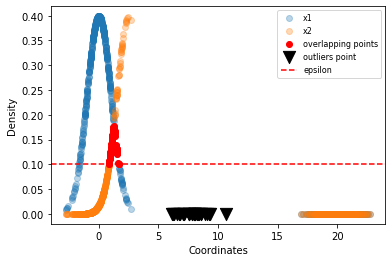

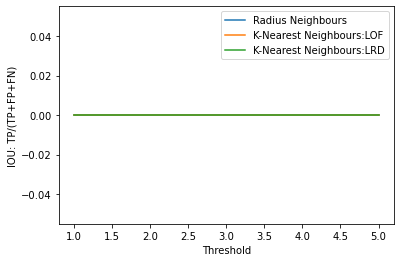

In [34]:
plot_with_seeding_multiple_dim()